In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from graph_reinforcement_learning_using_blockchain_data import config
from graph_reinforcement_learning_using_blockchain_data.modeling import random_forest

config.load_dotenv()

True

In [13]:
df_features = pd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_without_0logs.csv"
)
df_embeddings = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "embeddings_128.csv")

In [14]:
df_embeddings.head()

,transactionHash,embeddings
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,[ 0.6488047 0.8857084 0.80789745 0.175188...
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,[-1.01943046e-01 -1.50753886e-01 -1.45948857e-...
2,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,[ 0.6488047 0.8857084 0.80789745 0.175188...
3,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,[ 0.6488047 0.8857084 0.80789745 0.175188...
4,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...,[ 1.0032636 1.0859172 0.8387185 0.493998...


In [15]:
def parse_embedding(embedding_str):
    embedding_str = embedding_str.replace("\n", " ")
    embedding_array = np.fromstring(embedding_str.strip("[]"), sep=" ")
    return embedding_array


df_embeddings["embeddings"] = df_embeddings["embeddings"].apply(parse_embedding)

In [16]:
embedding_list = df_embeddings["embeddings"].tolist()
embedding_dim = embedding_list[0].shape[0]  # e.g. 128

embeddings_expanded = pd.DataFrame(
    embedding_list, columns=[f"emb_{i}" for i in range(embedding_dim)]
)
embeddings_expanded["transactionHash"] = df_embeddings["transactionHash"].values

In [17]:
embeddings_expanded.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,transactionHash
0,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...
1,-0.101943,-0.150754,-0.145949,-0.222893,-0.101609,-0.088858,-0.120292,0.223810,0.122644,0.105553,...,0.087557,0.063972,0.171073,0.106778,-0.096407,0.173654,0.108045,0.091411,0.204592,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...
2,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...
3,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...
4,1.003264,1.085917,0.838719,0.493998,1.003514,1.077829,0.926629,-1.344079,-1.026231,-1.244821,...,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...


In [18]:
print(len(df_features))
print(len(embeddings_expanded))
df_merged = df_features.merge(embeddings_expanded, how="inner", on="transactionHash")
print(len(df_merged))

180075
184132
180075


In [19]:
# df_merged = df_merged[df_merged["num_logs"].apply(lambda x: x is not None and x > 0)]

df_merged.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...,16950601,157316,2135061,12,50000000000,1,7865800000000000,0xf44329d7915C95Cad0510D8174accDFBceABc16d,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,1.046832,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723
1,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,16950601,48537,10131517,140,22000000000,1,1067814000000000,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
2,0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...,16950601,62833,5225102,71,19360969611,1,1216507803567963,0x584cE70eCfECeea309675726875e8E0Fdbc08b20,0xa24787320ede4CC19D800bf87B41Ab9539c4dA9D,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
3,0x3697d02c0d3b972fce90722bc42c91fe8a6d6d8137be...,16950601,172470,3799719,44,20100000000,1,3466647000000000,0x301e2D2a98c5873AC27Fd9eae85F0153959100Fa,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0.977257,-0.838083,-0.549349,-0.583719,-0.645372,0.355149,-0.283619,-0.650481,-0.292547,-0.898376
4,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,16950601,254032,2564577,16,22568554601,1,5733135062401232,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,...,-0.174104,0.145695,0.086302,0.184217,0.141733,-0.129550,0.216480,0.129744,0.140465,0.234399


In [20]:
df = df_merged.drop(columns=["transactionHash", "from", "to", "blockNumber", "transactionIndex"])
df.head()

,gasUsed,cumulativeGasUsed,effectiveGasPrice,status,fee,num_logs,dummy_0x1c411e9a,dummy_0xe1fffcc4,dummy_0xddf252ad,dummy_0xe9149e1b,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,157316,2135061,50000000000,1,7865800000000000,6,1,1,1,0,...,1.046832,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723
1,48537,10131517,22000000000,1,1067814000000000,1,0,0,1,0,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
2,62833,5225102,19360969611,1,1216507803567963,2,0,0,1,0,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
3,172470,3799719,20100000000,1,3466647000000000,5,0,0,1,0,...,0.977257,-0.838083,-0.549349,-0.583719,-0.645372,0.355149,-0.283619,-0.650481,-0.292547,-0.898376
4,254032,2564577,22568554601,1,5733135062401232,11,0,0,1,0,...,-0.174104,0.145695,0.086302,0.184217,0.141733,-0.129550,0.216480,0.129744,0.140465,0.234399


In [21]:
X = df.drop(columns=["label"])
# X = np.hstack([other_features, embedding_matrix])
y = df["label"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
features_to_scale = ["gasUsed", "cumulativeGasUsed", "effectiveGasPrice", "fee", "num_logs"]

In [24]:
rf_trainer = random_forest.RandomForestTrainer()
grid_search = rf_trainer.grid_search(features_to_scale)

In [25]:
best_model = rf_trainer.train(
    X_train, X_test, y_train, y_test, grid_search, "Edge Classification with GNN embeddings"
)

2025/05/31 13:25:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  27.9s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  27.7s
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 1.1min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 1.1min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 1.1min
[CV] END classifier__max_depth=20, clas

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  15.3s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  15.7s
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 3.0min
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 2.9min
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time= 6.1min
[CV] END classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=2, cl

2025/05/31 13:54:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).
"
2025/05/31 13:54:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/ve

🏃 View run redolent-shoat-647 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/52718a630c5c4071bb0448a2dc2c5246
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run popular-lamb-948 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/767adcc2fd914b219a7bb101138d81f8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run blushing-trout-548 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/2928fcc8a576429ea77aecabc3c8925d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run industrious-dog-103 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/ff22f37935c240ba96800e52fe2800fe
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run adorable-deer-705 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/4895e73fc13b4b9ab67acc8209c59611
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/9

2025/05/31 13:54:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


🏃 View run abrasive-gnat-450 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/788f48b93d7c4aba889560a516d21416
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575


In [26]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE score: {-grid_search.best_score_:.3f}")

Best parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 30}
Best RMSE score: -0.989


In [27]:
rf = best_model

In [28]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Train Accuracy: 0.9928571428571429
Test Accuracy: 0.9891989448840761


In [29]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

2025/05/31 13:55:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14900
           1       0.98      1.00      0.99     21115

    accuracy                           0.99     36015
   macro avg       0.99      0.99      0.99     36015
weighted avg       0.99      0.99      0.99     36015



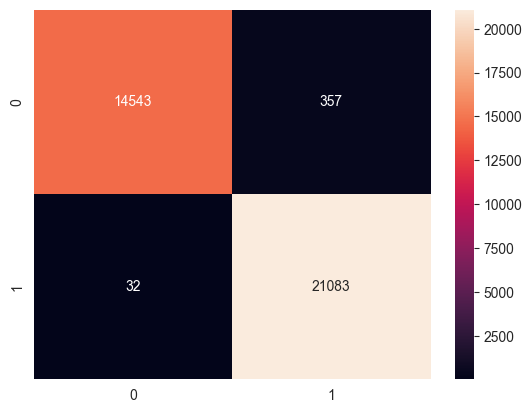

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

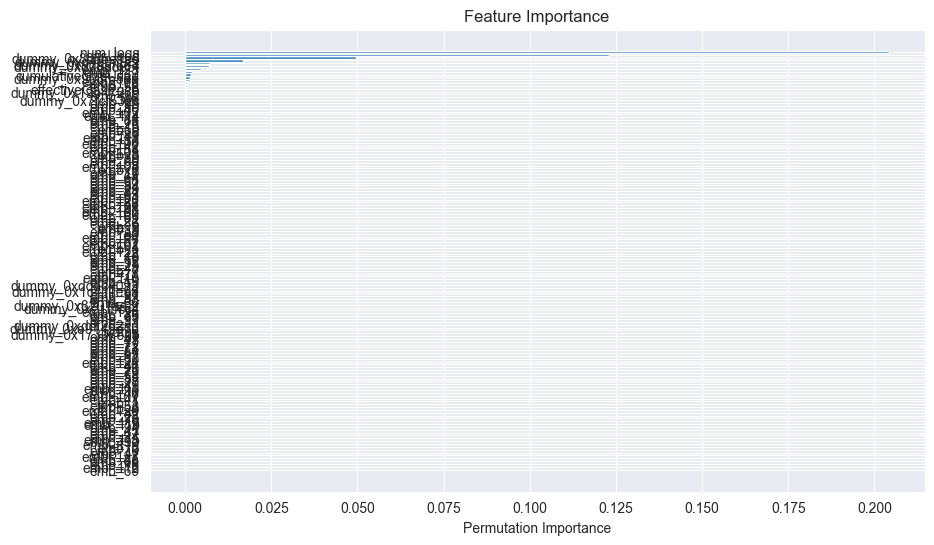

In [31]:
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()